In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import sys
sys.path.insert(0,'../src/')

import baseline
import zipreg 
import zipgate_reg
from inference import *
from criticism import *
from preprocess_bikeshare import *



In [3]:
#Set some plot params
import matplotlib.pyplot as plt
large = 16; med = 14; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [4]:
# Set to true for fast run of notebook
QUICK_RUN = True

if QUICK_RUN:
    iters = 3000
    with open('../data/final_train_small.pickle', 'rb') as f:
        train=pickle.load(f)
    with open('../data/final_test_small.pickle', 'rb') as f:
        test=pickle.load(f)
else:
    iters = 10000
    with open('../data/final_train.pickle', 'rb') as f:
        train=pickle.load(f)
    with open('../data/final_test.pickle', 'rb') as f:
        test=pickle.load(f)
        
stations = pd.read_csv('../data/stations.csv')

In [5]:
# import importlib
# importlib.reload(criticism)

## Data

Our data [cite] ranges over 2 years and includes approximately 670,000 trips taken over that time period. First, a look at some of the basic trends shows us a wide variety of demand at each station and cyclic demand patterns throughout the day on the week and weekend. Included along with this data is information about the stations themselves (number of bike racks) as well as daily weather data. We aggregated this data into 3 hour chunks to make
inference a little quicker and realizing we didn't need the granularity that 1 hour chunks provided. 

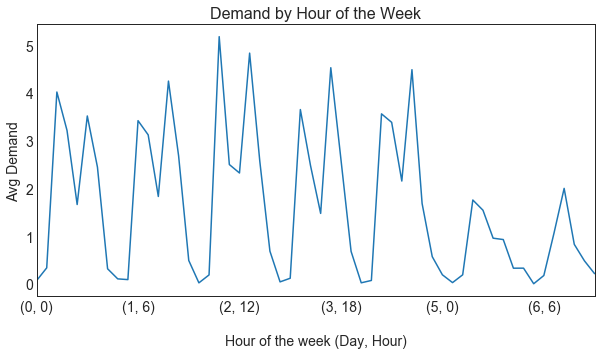

In [6]:
train.groupby(['weekday','hour'])['demand'].mean().plot.line(figsize = (10,5))
plt.xlabel('\nHour of the week (Day, Hour)')
plt.ylabel('Avg Demand')
plt.title('Demand by Hour of the Week', fontsize=16)
plt.show()

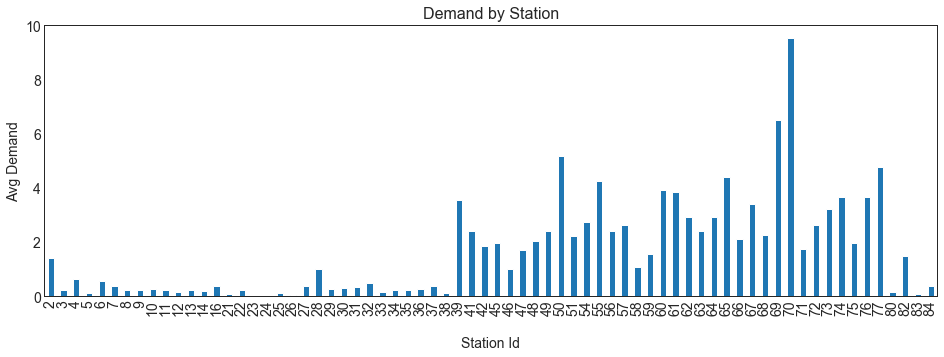

In [7]:
train.groupby(['start_station_id'])['demand'].mean().plot.bar(figsize = (16,5))
plt.xlabel('\nStation Id')
plt.ylabel('Avg Demand')
plt.title('Demand by Station', fontsize=16)
plt.show()

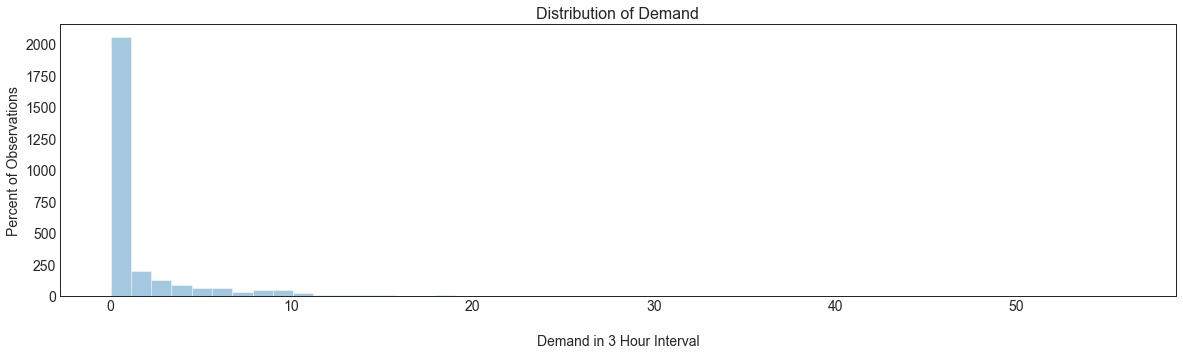

In [8]:
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(20,5))
plt.figure(figsize=(20,5))
sns.distplot(train['demand'],norm_hist=False, kde = False)
plt.xlabel('\nDemand in 3 Hour Interval')
plt.ylabel('Percent of Observations')
plt.title('Distribution of Demand', fontsize=16)
plt.show()

## Model 1: Model Formulation

We thought a regression would be a sound way to model the data rather than timeseries based methods. We are trying to 
model demand uncertainty based off various factors. A regression can capture a large portion of this information given our patterns are largely cyclical. We decided to first apply Poisson regression. Though the distribution above suggests that Poisson may not be the best fit, it is a good starting point for modeling count data. 

We started with some simple assumptions that our rate of arrivals depend on two latent arrival components for stations and time:

$$\text{station s} = \mu_s$$
$$\text{time (weekday w, hour h)} = \mu_{w,h} $$
$$w \in \{\text{weekday, weekend}\}, h \in \{0,3,6,9,12,15,18,21\}$$

Our priors on our latent components are simply:

$$\mu_s, \mu_{w,h} \sim \mathcal{N}(0,1)$$

We assume for this model that demand observation $i$ at a station $s$ and time $w,h$ follow a Poisson distribution:

$$d_{i,s,w,h} \sim Pois(\lambda_{s,w,h})$$

$$\lambda_{s,w,h} = \exp\{\mu_s+\mu_{w,h} \}$$

Let $M_{s,w,h}$ be the number of observations at a station $s$ and time $w,h$.We can write the joint probability for this model as

$$p(d,\mu_s,\mu_{w,h}) = \prod_{s \in S}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_s^2}{2}}\prod_{w \in W}\prod_{h \in H}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_{w,h}^2}{2}}\prod_{i = 1}^{M_{s,w,h}} \frac{e^{d_{i, s,w,h}(\mu_s+\mu_{w,h})}e^{-\mu_s-\mu_{w,h}}}{d_{i, s,w,h}!}$$

## Model 1: Inference

In [9]:
b_data, b_features = baseline.feature_generation(train)
b_data_test, _ = baseline.feature_generation(test)
b = baseline.PoissReg(b_features, b_data)

In [10]:
#Perform SVI
svi_baseline, elbo_loss = run_svi(b.model, b.guide,
                                 iters=iters,
                                 data=b_data['data'],
                                 demand=b_data['demand'],
                                 filename='../models/svi_baseline_params.pkl')

svi_posterior_baseline = get_svi_posterior(b_data['data'], b_data['demand'],
                                          svi=svi_baseline)

print(f"WAIC: {float(svi_posterior_baseline.information_criterion()['waic'].detach().numpy())}")

#plot_elbo(elbo_loss[3000:])

../src/baseline.py:86: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  with pyro.plate("data", len(data)):
Elbo loss: 18065.01171875
Elbo loss: 5612.1533203125
Elbo loss: 4905.4033203125
Elbo loss: 3916.313232421875
Elbo loss: 3927.161376953125
Elbo loss: 3823.2373046875


WAIC: 8532.1953125


In [11]:
# # Load parameters from inference
# svi_posterior_baseline = get_svi_posterior(b_data['data'], b_data['demand'],
#                                     model = b.model,
#                                   guide = b.guide,
#                                   filename='../models/svi_baseline_params.pkl')


## Model 1: Criticism

In [12]:
post_samples_base = ppd_samples(
    b.wrapped_model,
    svi_posterior_baseline,
    b_data_test,
    ['obs'],
    num_samples=1000).squeeze()

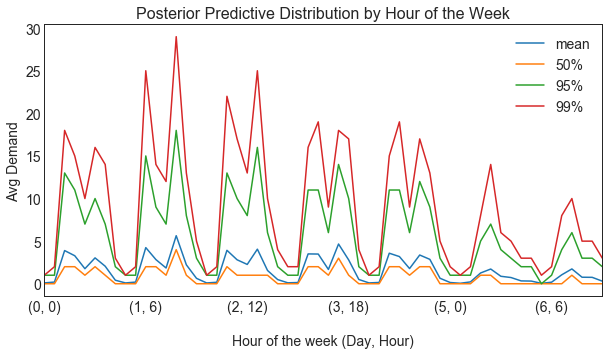

In [13]:
post_combined = align_regressors_ppd(test, post_samples_base)
post_combined.groupby(['weekday','hour'])['value'].describe(percentiles = [.5,.95,.99])[['mean','50%','95%','99%']].plot(figsize = (10,5))
plt.xlabel('\nHour of the week (Day, Hour)')
plt.ylabel('Avg Demand')
plt.title('Posterior Predictive Distribution by Hour of the Week', fontsize=16)
plt.show()

We can see with some simple checks of the posterior predictive distribution (PPD) that a Poisson distribution may not be the best assumption. We underestimate the number of demand observations with no bikes taken off the rack. 

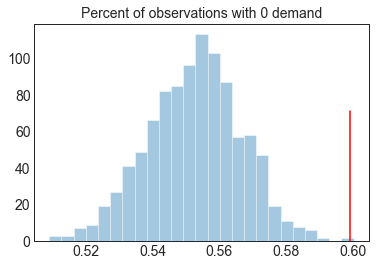

In [14]:
compare_test_statistic(test.demand.values, post_samples_base,
                       stat=perc_0, title = 'Percent of observations with 0 demand')


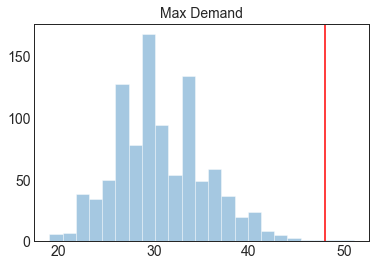

In [15]:
compare_test_statistic(test.demand.values, post_samples_base,
                       stat=max_, title = 'Max Demand')

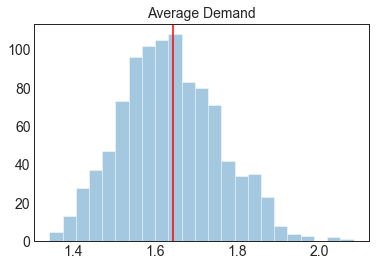

In [16]:
compare_test_statistic(test.demand.values, post_samples_base, stat=mean, title = 'Average Demand')

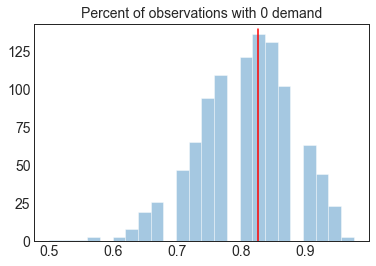

In [19]:
indx = (test.start_station_id==10)

compare_test_statistic(test.demand.values[indx], post_samples_base[:,indx],
                       stat=perc_0, title = 'Percent of observations with 0 demand')


## Rethinking Poisson

We can model the average rate with a Poisson assumption well, but the variation is restricted to be equal to $\lambda$. The demand distribution is overdispersed as seen by the average and variance below. Since we underestimate the percentage of time periods with no demand, a Zero Inflated Poisson may be a better assumption. 

In [20]:
#Overdispersed 
print(f'Demand mean: {train["demand"].mean().round(3)}')
print(f'Demand var: {train["demand"].var().round(3)}')
      

Demand mean: 1.673
Demand var: 13.575


In [21]:
# Distribution of overdispersion (Var(x)/E[x]) by station and time
m_v = train.groupby(['start_station_id','weekday','hour'])['demand'].agg(['mean','var'])
(m_v['var']/m_v['mean']).describe()

count    316.000000
mean       1.373450
std        1.809545
min        0.000000
25%        0.312500
50%        1.000000
75%        1.892534
max       17.064516
dtype: float64

# Model 2: Model Formulation

Now we assume that demand follows a Zero Inflated Poisson distribution (ZIP) which can be thought of as a mixture of a poisson and bernoulli. 

$$p(k) = (1-\rho)\frac{\lambda^k e^{-\lambda}}{k!} + \rho {1}_{k=0}$$



We keep the same priors on our station and time latent factors. 

We assume that we have one global $\rho$ where
$$\rho \sim Beta(\alpha, \beta)$$ 

and we impose another level of priors encoding an initial belief that $\rho<.5$:
$$\alpha \sim Gamma(2,2)$$
$$\beta \sim Gamma(3,2)$$

Again, our assumtion on demand:

$$d_{i,s,w,h} \sim ZIP(\rho,\lambda_{s,w,h})$$

$$\lambda_{s,w,h} = \exp\{\mu_s+\mu_{w,h} \}$$

Our new joint probability for this model is:
$$p(d,\mu_s,\mu_{w,h}) = \frac{2^2}{\Gamma(2)}\alpha e^{-2\alpha}\frac{2^3}{\Gamma(3)}\beta e^{-2\beta}\frac{1}{B(\alpha, \beta)}\rho^{\alpha-1}(1-\rho)^{\beta-1}\prod_{s \in S}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_s^2}{2}}\prod_{w \in W}\prod_{h \in H}\frac{1}{\sqrt{2\pi}}e^{\frac{-\mu_{w,h}^2}{2}}\prod_{i = 1}^{M_{s,w,h}} \left[(1-\rho)\frac{e^{d_{i, s,w,h}(\mu_s+\mu_{w,h})}e^{-\mu_s-\mu_{w,h}}}{d_{i, s,w,h}!}+ \rho1_{d_{i, s,w,h}=0}\right]$$

### ZIP (shared gate parameter)

In [22]:
z_data, z_features = zipreg.feature_generation(train)
z_data_test,_ = zipreg.feature_generation(test)
z = zipreg.ZIPoissReg(z_features, z_data)


In [25]:
# Perform SVI
svi_zip, elbo_loss = run_svi(z.model, z.guide,
                                 iters=iters,
                                 data=z_data['data'],
                                 demand=z_data['demand'],
                                 filename='../models/svi_zip_params.pkl')

svi_posterior_zip = get_svi_posterior(z_data['data'], z_data['demand'],
                                          svi=svi_zip)

#plot_elbo(elbo_loss[3000:])
print(f"WAIC: {float(svi_posterior_zip.information_criterion()['waic'].detach().numpy())}")


../src/zipreg.py:114: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  gate_alpha_loc = pyro.param('gate_alpha_loc', torch.tensor(3.),
../src/zipreg.py:116: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  gate_beta_loc = pyro.param('gate_beta_loc', torch.tensor(3.),
../src/zipreg.py:148: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be th

WAIC: 8141.9951171875


In [ ]:
# svi_posterior_zip = get_svi_posterior(z_data['data'], z_data['demand'],
#                                 model = z.model,
#                                   guide = z.guide,
#                                   filename='../models/svi_zip_params.pkl')

In [26]:
post_samples_zip = ppd_samples(
    z.wrapped_model,
    svi_posterior_zip,
    z_data_test,
    ['obs'],
    num_samples=1000).squeeze()

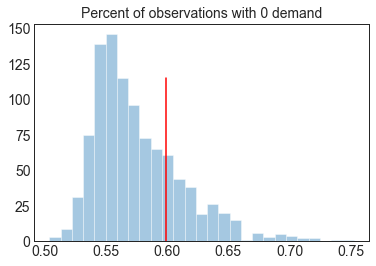

In [27]:
compare_test_statistic(test.demand.values, post_samples_zip,
                       stat=perc_0, title = 'Percent of observations with 0 demand')


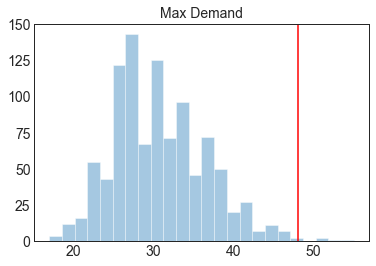

In [28]:
compare_test_statistic(test.demand.values, post_samples_zip,
                       stat=max_, title = 'Max Demand')

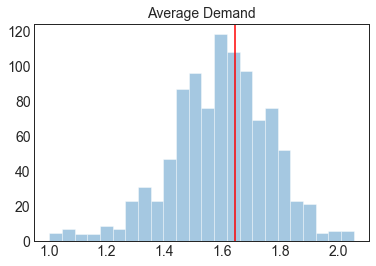

In [29]:
compare_test_statistic(test.demand.values, post_samples_zip, stat=mean, title = 'Average Demand')

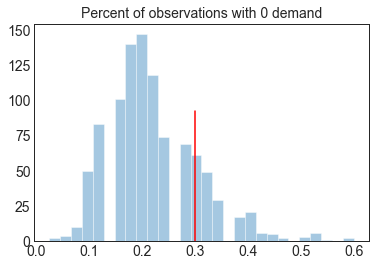

In [32]:
indx = (test.start_station_id==70)

compare_test_statistic(test.demand.values[indx], post_samples_zip[:,indx],
                       stat=perc_0, title = 'Percent of observations with 0 demand')


### ZIP (logit gate parameter)

In [ ]:
zg_data, zg_features = zipgate_reg.feature_generation(train)
zg_data_test, _ = zipgate_reg.feature_generation(test)
zg = zipgate_reg.ZIPoissRegGate(zg_features, zg_data)

In [ ]:
# Perform SVI
svi_zipgate, elbo_loss = run_svi(zg.model, zg.guide,
                                 iters=10000,
                                 data=zg_data['data'],
                                 demand=zg_data['demand'],
                                 filename='../models/svi_zipgate_params.pkl')

svi_posterior_zipgate = get_svi_posterior(zg_data['data'], zg_data['demand'],
                                          svi=svi_zipgate)

plot_elbo(elbo_loss[3000:])

In [ ]:
# svi_posterior_zipgate = get_svi_posterior(zg_data['data'], zg_data['demand'],
#                                 model = zg.model,
#                                   guide = zg.guide,
#                                   filename='../models/svi_zipgate_params.pkl')

In [ ]:
post_samples_zipgate = ppd_samples(
    zg.wrapped_model,
    svi_posterior_zipgate,
    zg_data_test,
    ['obs'],
    num_samples=1000)


In [ ]:
svi_posterior_zipgate.information_criterion()


In [ ]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=perc_0)
plt.title('Percent of observations with 0 demand')


In [ ]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=max_)
plt.title('Max demand')


In [ ]:
compare_test_statistic(test.demand.values, post_samples_zipgate,
                       stat=mean)
plt.title('Avg demand')


In [ ]:
station_indx = ((test.start_station_id==70) )
compare_test_statistic(test[station_indx ].demand.values, post_samples_zipgate[:,:,station_indx.values ],
                       stat=perc_0)
plt.title('Percent of observations with 0 demand at station 70 ')


### Station Viz

In [56]:
with open('../data/demand_3h.pickle', 'rb') as f:
    data = pickle.load(f)
    
    

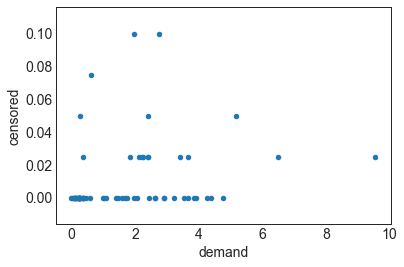

In [245]:
train.groupby('start_station_id')[['censored','demand']].mean().plot.scatter(x = 'demand', y = 'censored')
